In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16

In [2]:
# Load and preprocess images using the data generator
image_folder = '/content/drive/MyDrive/REX Technologies/img_align_celeba'
# Load the CSV file with image labels (-1 for female, 1 for male)
label_file_path = '/content/drive/MyDrive/REX Technologies/list_attr_celeba.csv'  # Replace with the path to your CSV file
df = pd.read_csv(label_file_path)
df = df.iloc[0:5000,]
df['img_path'] = "/content/drive/MyDrive/REX Technologies/img_align_celeba/" + df["image_id"]

In [3]:
# Define image and batch parameters
image_size = (64, 64)
batch_size = 32

# Split data into training (60%), validation (20%), and test (20%) sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, validation_df = train_test_split(train_df, test_size=0.25, random_state=42)

# Convert integer labels to strings
train_df['Male'] = train_df['Male'].astype(str)
validation_df['Male'] = validation_df['Male'].astype(str)
test_df['Male'] = test_df['Male'].astype(str)

# Create data generator for image loading and resizing
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
)


train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_folder,
    x_col='img_path',
    y_col='Male',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=image_folder,
    x_col='img_path',
    y_col='Male',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_folder,
    x_col='img_path',
    y_col='Male',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
)

Found 3000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [4]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [5]:
# Freeze the layers of the pretrained model
for layer in vgg16_base.layers:
    layer.trainable = False

In [8]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
model_vgg16 = tf.keras.Sequential([
    vgg16_base,
    Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# Compile the VGG16-based model
model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
# Train the VGG16-based model
epochs_vgg16 = 20
history_vgg16 = model_vgg16.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs_vgg16,
    verbose=1
)
model_vgg16.save("/content/drive/MyDrive/REX Technologies/CNN_model_save/gender_classification_fine_tune_vgg16_model_1.h5")

Epoch 1/20
94/94 [==============================] - 8s 88ms/step - loss: 0.1054 - accuracy: 0.9573 - val_loss: 0.4872 - val_accuracy: 0.8700
Epoch 2/20
94/94 [==============================] - 8s 85ms/step - loss: 0.0790 - accuracy: 0.9687 - val_loss: 0.4349 - val_accuracy: 0.8620
Epoch 3/20
94/94 [==============================] - 8s 82ms/step - loss: 0.0811 - accuracy: 0.9677 - val_loss: 0.5893 - val_accuracy: 0.8460
Epoch 4/20
94/94 [==============================] - 8s 88ms/step - loss: 0.0602 - accuracy: 0.9800 - val_loss: 0.5407 - val_accuracy: 0.8610
Epoch 5/20
94/94 [==============================] - 8s 83ms/step - loss: 0.0486 - accuracy: 0.9810 - val_loss: 0.7032 - val_accuracy: 0.8590
Epoch 6/20
94/94 [==============================] - 8s 89ms/step - loss: 0.0306 - accuracy: 0.9887 - val_loss: 0.7742 - val_accuracy: 0.8600
Epoch 7/20
94/94 [==============================] - 8s 85ms/step - loss: 0.0291 - accuracy: 0.9883 - val_loss: 0.6343 - val_accuracy: 0.8530
Epoch 8/20
94

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 2s 61ms/step
VGG16 Fine-Tuning Results:
Accuracy: 0.84
F1 Score: 0.81
Recall: 0.80
Confusion Matrix:
[[516  75]
 [ 82 327]]


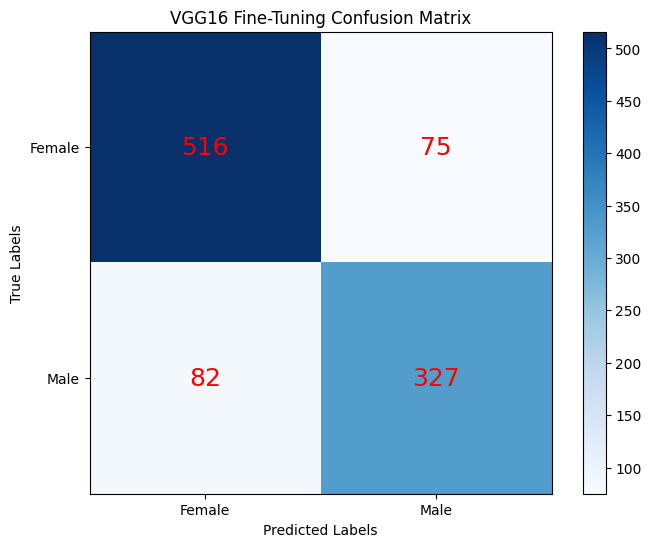

In [12]:
# Evaluate the VGG16-based model on the test set
y_true_vgg16 = test_generator.classes
y_pred_vgg16 = (model_vgg16.predict(test_generator) > 0.5).astype("int32")

# Calculate evaluation metrics for VGG16-based model
accuracy_vgg16 = accuracy_score(y_true_vgg16, y_pred_vgg16)
f1_vgg16 = f1_score(y_true_vgg16, y_pred_vgg16)
recall_vgg16 = recall_score(y_true_vgg16, y_pred_vgg16)
confusion_vgg16 = confusion_matrix(y_true_vgg16, y_pred_vgg16)

# Print evaluation metrics for VGG16-based model
print("VGG16 Fine-Tuning Results:")
print(f"Accuracy: {accuracy_vgg16:.2f}")
print(f"F1 Score: {f1_vgg16:.2f}")
print(f"Recall: {recall_vgg16:.2f}")
print("Confusion Matrix:")
print(confusion_vgg16)

# Plot confusion matrix for VGG16-based model
plt.figure(figsize=(8, 6))
plt.imshow(confusion_vgg16, cmap=plt.cm.Blues)
plt.title("VGG16 Fine-Tuning Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks([0, 1], ['Female', 'Male'])
plt.yticks([0, 1], ['Female', 'Male'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(confusion_vgg16[i, j]), ha='center', va='center', color='red', fontsize=18)
plt.show()